### Creating Model 3

* Creating a 3rd model for the NFL Play data. The goal is to predict the play type on 4th down.
* Logistic Regression & Random Forest have been completed, so the next step is gradient boosted trees.

In [1]:
from pyspark.ml import Pipeline  
from pyspark.ml.feature import *  
from pyspark.ml.classification import LogisticRegression
import nfl_data_py as nfl
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
import pandas as pd
from imblearn.combine import SMOTEENN
from DataPipelineFxn import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

In [2]:
# get the spark session and data frame
data = GetSparkDF(include_undersample = True)

2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/02 16:28:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/02 16:29:13 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/12/02 16:29:14 WARN TaskSetManager: Stage 0 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 16:29:16 WARN TaskSetManager: Stage 3 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 16:29:21 WARN TaskSetManager: Stage 4 contains a task of very large size (3174 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 16:29:23 WARN TaskSetManager: Stage 5 contains a task of very large size (1934 KiB). The maximum recommended task s

In [3]:
spark, df, test_df, undersample_df = data

### Create the Model Pipeline

In [4]:
from pyspark.ml.classification import NaiveBayes

In [5]:
str_col = ["home_team", "away_team", "season_type", "posteam", "posteam_type", "defteam", "side_of_field", "game_half",
        "play_type", "season", 'roof', 'surface']
str_col_output = ["home_team_idx", "away_team_idx", "season_type_idx", "posteam_idx", "posteam_type_idx", "defteam_idx",
                  "side_of_field_idx", "game_half_idx", "play_type_idx", "season_idx", 'roof_idx', 'surface_idx']
ohe_col_input = ["home_team_idx", "away_team_idx", "season_type_idx", "posteam_idx", "posteam_type_idx", "defteam_idx",
                  "side_of_field_idx", "game_half_idx", "season_idx", 'roof_idx', 'surface_idx']
ohe_col_vec = ["home_team_vec", "away_team_vec", "season_type_vec", "posteam_vec", "posteam_type_vec", "defteam_vec",
                  "side_of_field_vec", "game_half_ivec", "season_vec", 'roof_vec', 'surface_vec']


# process using string indexer first for catgeorical features  
stringIndexer = StringIndexer(inputCols=str_col, outputCols=str_col_output)

# process rating data into second feature
ohe = OneHotEncoder(inputCols=ohe_col_input, outputCols=ohe_col_vec) 

# Assemble features column
va = VectorAssembler(inputCols=ohe_col_vec, outputCol="features") 

# process data using maxabs scaler, not necessarily important for trees but consistency
scaler = MaxAbsScaler(inputCol="features", outputCol="scaledFeatures")

# define the model
nb = NaiveBayes(
    featuresCol = 'features', labelCol = 'play_type_idx'
)

# Fit the pipeline
pipeline = Pipeline(stages=[stringIndexer, ohe, va, scaler, nb])

In [6]:
# hyperparameter search across max depth, bins, and iterations
# paramGrid = ParamGridBuilder()\
#     .addGrid(gbt.maxDepth, np.arange(10, 100, step = 10)) \
#     .addGrid(gbt.maxIter, [20, 50, 100, 200])\
#     .addGrid(gbt.maxBins, np.arange(10, 100, step = 10))\
#     .build()

paramGrid = ParamGridBuilder()\
    .addGrid(nb.smoothing, np.arange(0.05, 1, step = 0.05)) \
    .build()

# build the evaluator
evaluator = MulticlassClassificationEvaluator(
    predictionCol="prediction",
    labelCol="play_type_idx",
    metricName="accuracy"
)

# set up the train validation split
tvs = TrainValidationSplit(
    estimator=pipeline,
    evaluator=evaluator,
    estimatorParamMaps=paramGrid,
    # 80% of the data will be used for training, 20% for validation.
    trainRatio=0.8
)

In [7]:
df.select(df.roof).distinct().show()

24/12/02 16:29:32 WARN TaskSetManager: Stage 6 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.


+--------+
|    roof|
+--------+
|outdoors|
|  closed|
|    open|
|    dome|
+--------+



In [8]:
# need to replace the empty string in surface
df = df.withColumn(
    'surface',
    F.when(df.surface == '', 'Undefined').otherwise(df.surface)
)

undersample_df = undersample_df.withColumn(
    'surface',
    F.when(undersample_df.surface == '', 'Undefined').otherwise(undersample_df.surface)
)

# fit the model with the hyperparameter search
nb_model = tvs.fit(df)

# fit to undersample as well
nb_undersample_model = tvs.fit(undersample_df)

24/12/02 16:29:33 WARN TaskSetManager: Stage 9 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 16:29:35 WARN TaskSetManager: Stage 12 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 16:29:37 WARN TaskSetManager: Stage 15 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 16:29:38 WARN TaskSetManager: Stage 18 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 16:29:39 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/12/02 16:29:39 WARN TaskSetManager: Stage 20 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 16:29:39 WARN TaskSetManager: Stage 23 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 16:29:40 WARN TaskSetManager: Sta

### Evaluate the Models

#### Non-Undersample

In [9]:
best_model = nb_model.bestModel

# Extract the parameter map of the best model
best_params = best_model.stages[-1].extractParamMap()

# Print the parameters values
print("Tuned Parameters of the Best Model:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")

Tuned Parameters of the Best Model:
featuresCol: features
labelCol: play_type_idx
modelType: multinomial
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
smoothing: 0.05


In [10]:
# have to change test df instance
test_df = test_df.withColumn(
    'surface',
    F.when(test_df.surface == '', 'Undefined').otherwise(test_df.surface)
)

prediction = best_model.transform(test_df)

In [11]:
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='f1'
)

accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='accuracy'
)

precision_by_label_eval = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='precisionByLabel'
)

f1_score = f1_evaluator.evaluate(prediction)
accuracy = accuracy_evaluator.evaluate(prediction)
precision_by_label = precision_by_label_eval.evaluate(prediction)

24/12/02 16:30:38 WARN TaskSetManager: Stage 445 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 16:30:39 WARN TaskSetManager: Stage 446 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 16:30:43 WARN TaskSetManager: Stage 455 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 16:30:44 WARN TaskSetManager: Stage 456 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 16:30:47 WARN TaskSetManager: Stage 465 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 16:30:48 WARN TaskSetManager: Stage 466 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.


In [12]:
prediction.select([prediction.play_type_idx, prediction.prediction]).show(10)

24/12/02 16:30:50 WARN TaskSetManager: Stage 475 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 16:30:51 WARN TaskSetManager: Stage 476 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.


+-------------+----------+
|play_type_idx|prediction|
+-------------+----------+
|          1.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          4.0|       0.0|
|          1.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
+-------------+----------+
only showing top 10 rows



In [13]:
prediction.groupby(prediction.prediction).count().show()

24/12/02 16:30:53 WARN TaskSetManager: Stage 484 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 16:30:54 WARN TaskSetManager: Stage 485 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|62706|
|       1.0| 1364|
|       3.0|    1|
|       2.0|  538|
+----------+-----+



In [14]:
prediction.groupby(prediction.play_type_idx).count().show()

24/12/02 16:30:56 WARN TaskSetManager: Stage 498 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 16:30:57 WARN TaskSetManager: Stage 499 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.


+-------------+-----+
|play_type_idx|count|
+-------------+-----+
|          0.0|41679|
|          1.0|12679|
|          4.0| 2760|
|          3.0| 2813|
|          2.0| 4678|
+-------------+-----+



In [15]:
labels = prediction.select([prediction.play_type, prediction.play_type_idx]).distinct().orderBy(prediction.play_type_idx).select(prediction.play_type).collect()
labels = [x[0][0] for x in labels]

24/12/02 16:30:59 WARN TaskSetManager: Stage 512 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 16:31:00 WARN TaskSetManager: Stage 513 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.


In [16]:
test_df.groupby(test_df.play_type).count().show()

24/12/02 16:31:02 WARN TaskSetManager: Stage 537 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 16:31:02 WARN TaskSetManager: Stage 538 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----+
| play_type|count|
+----------+-----+
|field_goal|12679|
|   no_play| 2760|
|       run| 2813|
|      punt|41679|
|      pass| 4678|
+----------+-----+



In [17]:
results = f'''
F1: {f1_score}
Accuracy: {accuracy}
Precision by Label: {precision_by_label}
'''

print(results)


F1: 0.5157475756303482
Accuracy: 0.6369081706882942
Precision by Label: 0.64891716901094



In [18]:
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics

#Adapting code from https://www.kaggle.com/code/ashokkumarpalivela/multiclass-classification-using-pyspark for confusion matrix
preds_and_labels = prediction.select(['prediction','play_type_idx'])\
                              .withColumn('play_type_idx', col('play_type_idx')\
                              .cast(FloatType()))\
                              .orderBy('prediction')
    
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

24/12/02 16:31:05 WARN TaskSetManager: Stage 551 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 16:31:05 WARN TaskSetManager: Stage 552 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
/sfs/gpfs/tardis/home/ean8fr/distributed-computing-final/env/lib/python3.11/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[4.0691e+04 7.3700e+02 2.5100e+02 0.0000e+00 0.0000e+00]
 [1.2210e+04 3.5700e+02 1.1100e+02 1.0000e+00 0.0000e+00]
 [4.4500e+03 1.2600e+02 1.0200e+02 0.0000e+00 0.0000e+00]
 [2.7000e+03 7.1000e+01 4.2000e+01 0.0000e+00 0.0000e+00]
 [2.6550e+03 7.3000e+01 3.2000e+01 0.0000e+00 0.0000e+00]]


Text(95.72222222222221, 0.5, 'Actual')

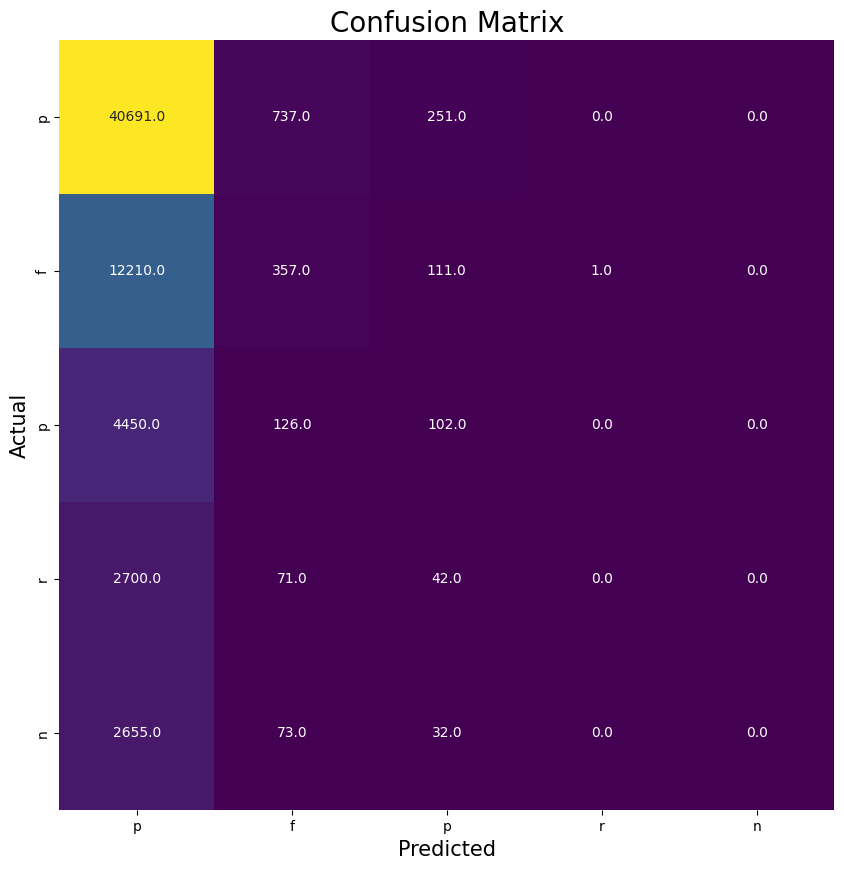

In [19]:
# labels = ["field_goal", "no_play", "pass", "punt", "run"]
_ = plt.figure(figsize=(10, 10))
ax = sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels,
            yticklabels=labels)

plt.title('Confusion Matrix', fontsize = 20) # title with fontsize 20
plt.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Actual', fontsize = 15) # y-axis label with fontsize 15

#### Undersample

Tuned Parameters of the Best Model:
featuresCol: features
labelCol: play_type_idx
modelType: multinomial
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
smoothing: 0.8


24/12/02 16:31:10 WARN TaskSetManager: Stage 575 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 16:31:11 WARN TaskSetManager: Stage 576 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 16:31:13 WARN TaskSetManager: Stage 585 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 16:31:14 WARN TaskSetManager: Stage 586 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 16:31:16 WARN TaskSetManager: Stage 595 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 16:31:17 WARN TaskSetManager: Stage 596 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 16:31:19 WARN TaskSetManager: Stage 605 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.


F1: 0.3049015542298733
Accuracy: 0.2548716123140739
Precision by Label: 0.21649746192893402



24/12/02 16:31:20 WARN TaskSetManager: Stage 606 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 16:31:22 WARN TaskSetManager: Stage 630 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
24/12/02 16:31:22 WARN TaskSetManager: Stage 631 contains a task of very large size (9437 KiB). The maximum recommended task size is 1000 KiB.
/sfs/gpfs/tardis/home/ean8fr/distributed-computing-final/env/lib/python3.11/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[ 2559.  2110.  3229.  2939.  1842.]
 [  436.   558.   859.   545.   362.]
 [  481.   743.  2157.   584.   713.]
 [ 7878.  7294. 10126. 10731.  5650.]
 [  466.   486.   863.   536.   462.]]


Text(95.72222222222221, 0.5, 'Actual')

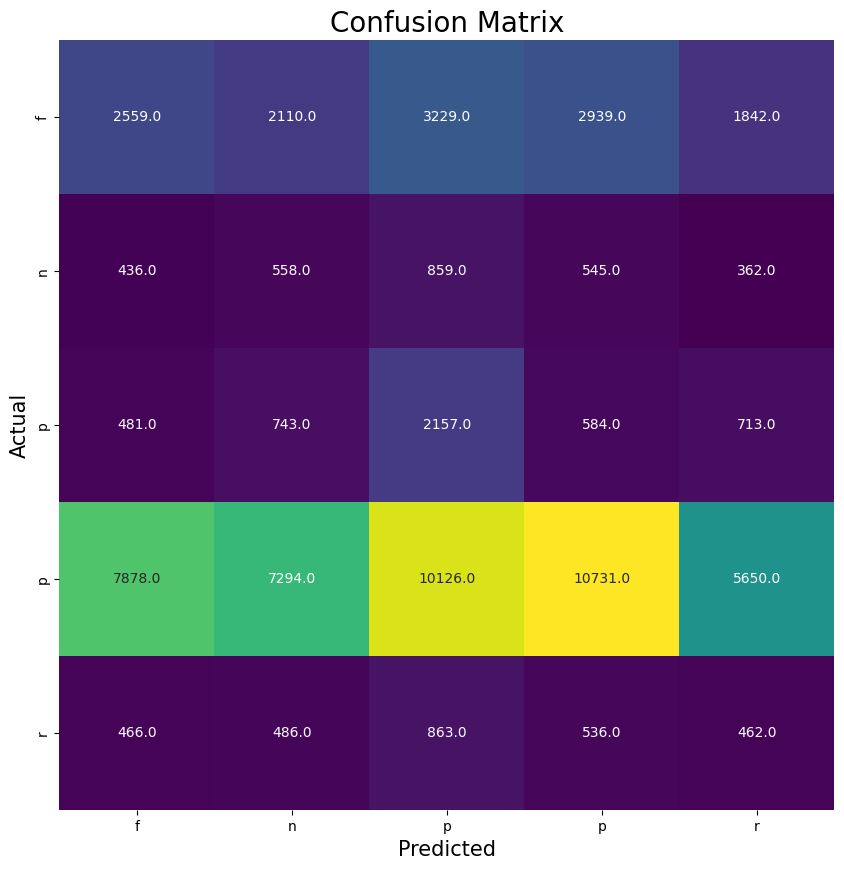

In [20]:
best_model = nb_undersample_model.bestModel

# Extract the parameter map of the best model
best_params = best_model.stages[-1].extractParamMap()

# Print the parameters values
print("Tuned Parameters of the Best Model:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")

# get prediction
prediction = best_model.transform(test_df)

# use same evaluators
f1_score = f1_evaluator.evaluate(prediction)
accuracy = accuracy_evaluator.evaluate(prediction)
precision_by_label = precision_by_label_eval.evaluate(prediction)

results = f'''
F1: {f1_score}
Accuracy: {accuracy}
Precision by Label: {precision_by_label}
'''

print(results)

labels = prediction.select([prediction.play_type, prediction.play_type_idx]).distinct().orderBy(prediction.play_type_idx).select(prediction.play_type).collect()
labels = [x[0][0] for x in labels]

preds_and_labels = prediction.select(['prediction','play_type_idx'])\
                              .withColumn('play_type_idx', col('play_type_idx')\
                              .cast(FloatType()))\
                              .orderBy('prediction')
    
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

_ = plt.figure(figsize=(10, 10))
ax = sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels,
            yticklabels=labels)

plt.title('Confusion Matrix', fontsize = 20) # title with fontsize 20
plt.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Actual', fontsize = 15) # y-axis label with fontsize 15

### Conclusions

Some quick observations:

* Much better performance when we don't undersample, could be because everything is a punt
* We need to be careful with the labels for the confusion matrix. They were not intially lining up properly with what the idxs are.
* I added temp, wind, roof, surface to the predictors